### Notes for features

- Lat Lon -> ZIP
- Zip -> popultation
- Zip -> sq. area
- Parking density / time

Simple features
- Lat Lon -> ZIP
- Lat Lon -> street
- group by zip
- group by street ( if you can match)
- we have GPS on both sides
- Working Hours Flag
- Rush Hour as Flag 8-10am Y m 5-7 Y
- Proximity to Holidays (by day)




In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import holidays
import sys
sys.path.append("../")
from common import get_train, get_test, feat_eng

font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 36}

matplotlib.rc('font', **font)

US_HOLIDAYS = holidays.UnitedStates()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [59]:
!ls /Users/timlee/data/sf_parking/

P_parking_clean.feather   ParkingSensorData.zip     prkg_sensor_sample_10.csv
P_parking_clean2.feather  SF_Sensor_Data.pdf        test-no-label-parking.csv
P_sensor.feather          parkingrecords.csv        train-parking.csv
P_sensor_clean.feather    parkingrecords.zip
ParkingSensorData.csv     prkg_sensor_sample.csv


In [60]:
!ls /Users/timlee/myrepos/final-project-chengcheng-tim/

FixingTrainStreets.docx         my_decorators.py
Parking_in_SF_word_version.docx ref_data
README.md                       report_imgs
__pycache__                     report_notes.md
archive                         scraping.py
chengs_rf_xgboost_nb.ipynb      scraping_nb
cleaning_data.py                street_dive.ipynb
common.py                       submissions
common.pyc                      tim_initial_model.ipynb
eda                             tims_model_w_parking.ipynb
gpspts                          tims_model_w_yelp.ipynb
mid_gps_id_4_yelp.pkl           ~$rking_in_SF_word_version.docx


In [61]:
'/Users/timlee/myrepos/final-project-chengcheng-tim/'

'/Users/timlee/myrepos/final-project-chengcheng-tim/'

In [62]:
data_path = '/Users/timlee/data/sf_parking/'

### Training Data

In [63]:
def extract_dates(df):
    tmp = df.copy()
    tmp['holiday'] = tmp['Date'].map(lambda x : 1 if x in US_HOLIDAYS else 0 )
    tmp['day']= tmp['Date'].dt.day
    tmp['mon']= tmp['Date'].dt.month
    tmp['dow']= tmp['Date'].dt.dayofweek
    tmp['week']= tmp['Date'].dt.week
    tmp['hour'] = tmp['Time'].map(lambda x : int(x.split(':')[0]))
    tmp['morn_night'] = tmp['hour'].map(lambda x : 0 if x <10 else 1 if x <17 else 2 )
    tmp['min'] = tmp['Time'].map(lambda x : int(x.split(':')[1]))
    return tmp

def add_tt_gps(df):
    tmp = df.copy()
    df_lkup = pd.read_csv('ref_data/train_test_addr_gps.txt', delimiter='|')
    df_lkup.columns = ['id','Street','From', 'From_lat','From_long','From_zip'] 
    tmp = tmp.merge(df_lkup, how='left', on=['Street', 'From'])
    df_lkup.columns = ['id','Street','To', 'To_lat','To_long','To_zip']
    tmp = tmp.merge(df_lkup, how='left', on=['Street', 'To'])
    return tmp

In [64]:
df_train = get_train()
df_train = feat_eng(df_train)

Time it took: 0.14942121505737305
adding additional features to test and/or train ...

loading parking data 1.7M
loading address data 30K
calculating closest joins
merging
complete
fixing neighborhood string formatting
merging in neighborhood information
Time it took: 0.6755790710449219


In [65]:
df_train['mon'].value_counts()

3    573
2    356
1    171
Name: mon, dtype: int64

In [66]:
df_train.head()

,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,holiday,day,...,apt4_pct,area,f_pop,house_avg_value,house_pct,m_pop,med_age,pop,twn_avg_value,twn_pct
0,Mission Street,25th Street,26th Street,2014-01-07,16:19,4,179.132970,1,0,7,...,12.6,1.049,38.4,972996.0,44.9,39.2,38.4,25825.0,1048521.0,18.5
1,Polk Street,Ellis Street,Olive Street,2014-01-18,20:42,0,52.740210,0,0,18,...,2.0,0.391,42.5,659375.0,1.6,41.9,42.5,14670.0,718750.0,2.0
2,Van Ness Avenue,Geary Boulevard,Myrtle Street,2014-01-18,20:39,0,52.517840,0,0,18,...,5.8,0.368,47.1,1407653.0,3.2,40.7,47.1,14331.0,1041250.0,6.6
3,Van Ness Avenue,Bush Street,Fern Street,2014-01-18,20:38,0,52.405315,0,0,18,...,NaN,0.036,45.9,NaN,NaN,42.2,45.9,1395.0,NaN,NaN
4,Van Ness Avenue,Daniel Burnham Court,Post Street,2014-01-18,20:38,0,52.191193,0,0,18,...,NaN,0.278,41.5,NaN,NaN,41.2,41.5,9194.0,NaN,NaN


### Street Analysis

### For scraping the GPS data

In [67]:
# street_combos = df_train.groupby(['Street','From'])['To'].count().reset_index()
# for row in street_combos.values:
#     print("%s and %s, San Francisco" % (row[0], row[1]))

In [68]:
# street_combos = df_train.groupby(['Street','To'])['From'].count().reset_index()
# for row in street_combos.values:
#     print("%s and %s, San Francisco" % (row[0], row[1]))

In [69]:
# street_combos = df_test.groupby(['Street','To'])['From'].count().reset_index()
# for row in street_combos.values:
#     print("%s and %s, San Francisco" % (row[0], row[1]))

In [70]:
street_combos1 = df_train.groupby(['Street','From'])['To'].count().reset_index()
a = street_combos1[['Street','From']].values

street_combos2 = df_train.groupby(['Street','To'])['From'].count().reset_index()
b = street_combos2[['Street','To']].values

street_combos3 = df_test.groupby(['Street','From'])['To'].count().reset_index()
c = street_combos3[['Street','From']].values

street_combos4 = df_test.groupby(['Street','To'])['From'].count().reset_index()
d = street_combos4[['Street','To']].values


total = list(a) + list(b) + list(c) + list(d)
total = [' and '.join(v) for v in total]
total = list(set(total))
for v in total:
    print(',"%s"'% v)

NameError: name 'df_test' is not defined

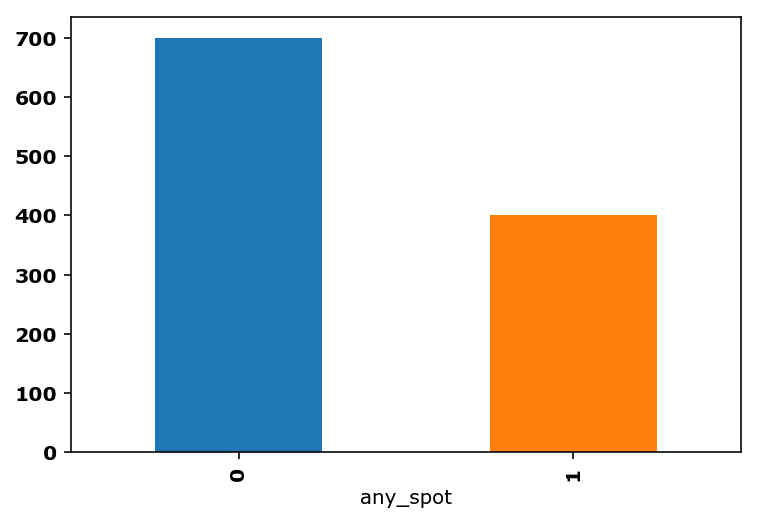

In [71]:
df_train.groupby('any_spot').size().plot(kind='bar')
plt.savefig('../report_imgs/any_spot_distr.png')

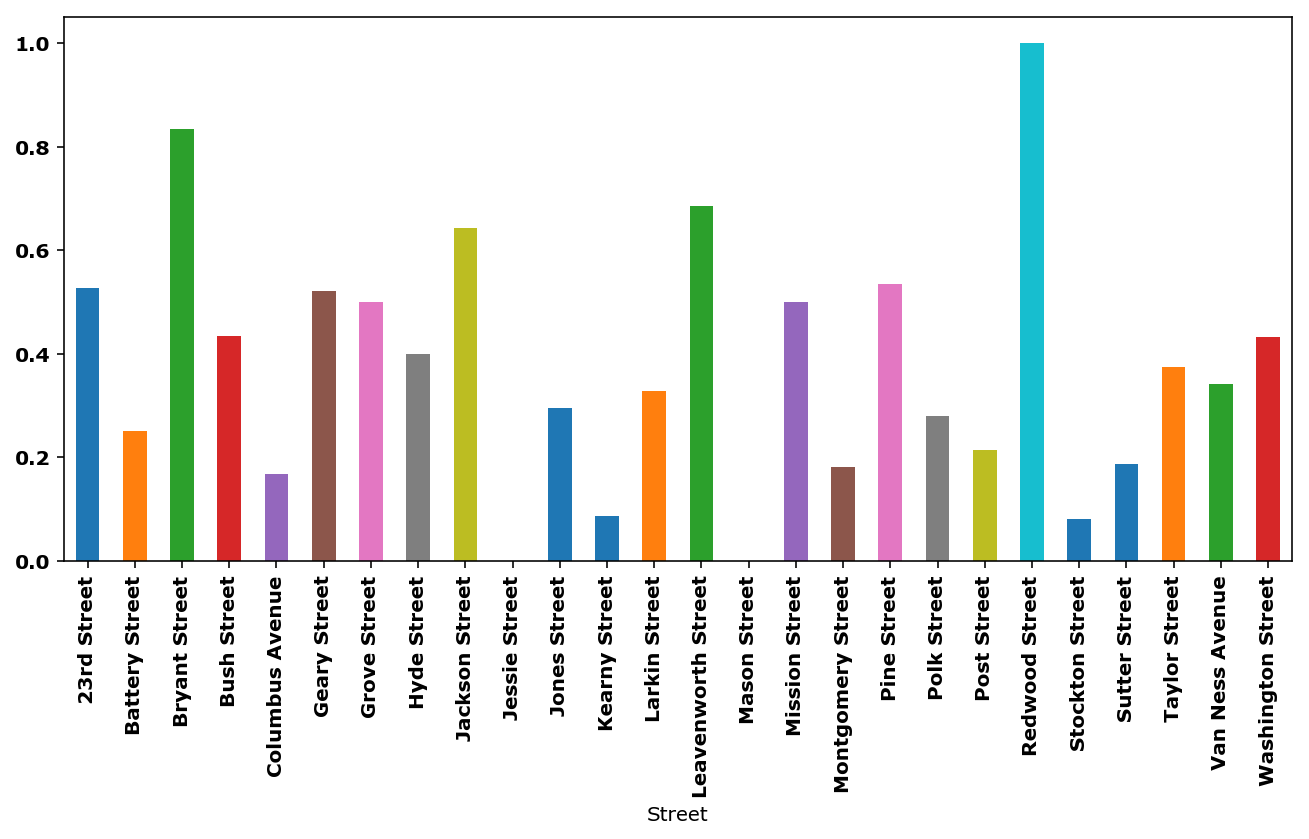

In [72]:
df_train.groupby(['Street'])['any_spot'].mean().plot(kind='bar', figsize=(11,5))
plt.savefig('../report_imgs/street_average.png')

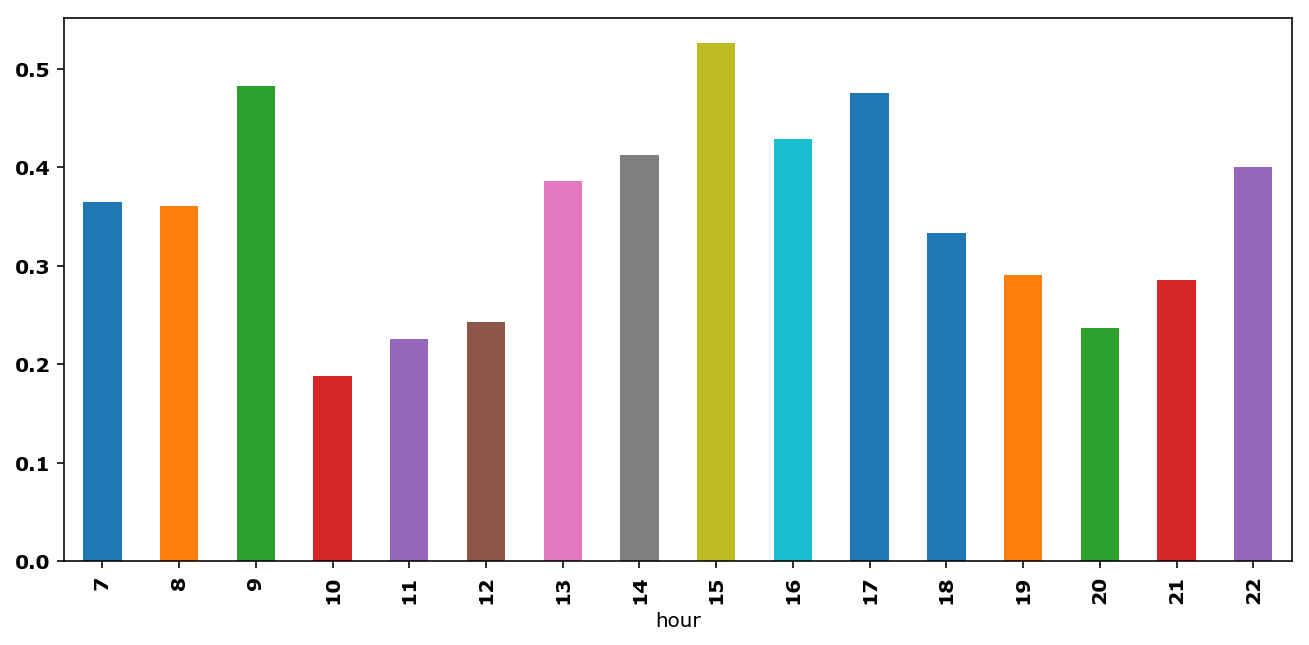

In [73]:
df_train.groupby(['hour'])['any_spot'].mean().plot(kind='bar', figsize=(11,5))
plt.savefig('../report_imgs/hour_average.png')

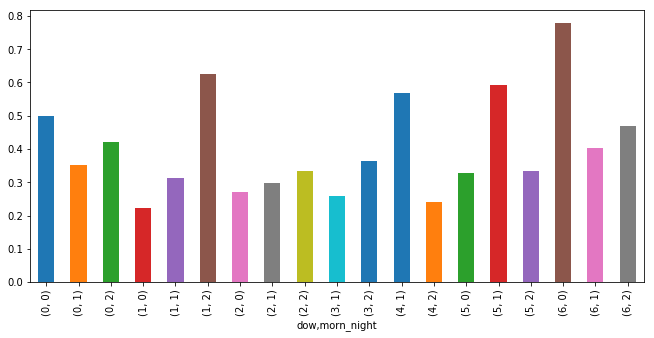

In [56]:
df_train.groupby(['dow', 'morn_night'])['any_spot'].mean().plot(kind='bar', figsize=(11,5))

### Parking Records

- Lat Lon -> ZIP
- Zip -> popultation
- Zip -> sq. area
- Parking density / time

Simple features
- Lat Lon -> ZIP
- Lat Lon -> street
- group by zip
- group by street ( if you can match)
- we have GPS on both sides 

In [3]:
import pandas as pd
data_path = '/Users/timlee/data/sf_parking/'
df_rec = pd.read_csv(data_path + 'parkingrecords.csv')

In [4]:
df_rec.head()

,lat,lon,datetime
0,37.771637,-122.437112,1471967637400
1,37.777229,-122.465370,1459821377952
2,37.771172,-122.437683,1461349554900
3,37.777328,-122.465012,1462252229600
4,37.778664,-122.464111,1463364111300


In [5]:
df_rec.shape

(1761328, 3)

In [6]:
uni_loc = df_rec.groupby(['lat','lon']).count().reset_index()

In [7]:
uni_loc.shape

(28159, 3)

In [8]:
uni_loc.head()

,lat,lon,datetime
0,37.711310,-122.404174,95
1,37.711318,-122.404866,33
2,37.711336,-122.404989,66
3,37.711339,-122.404248,39
4,37.711340,-122.403968,71


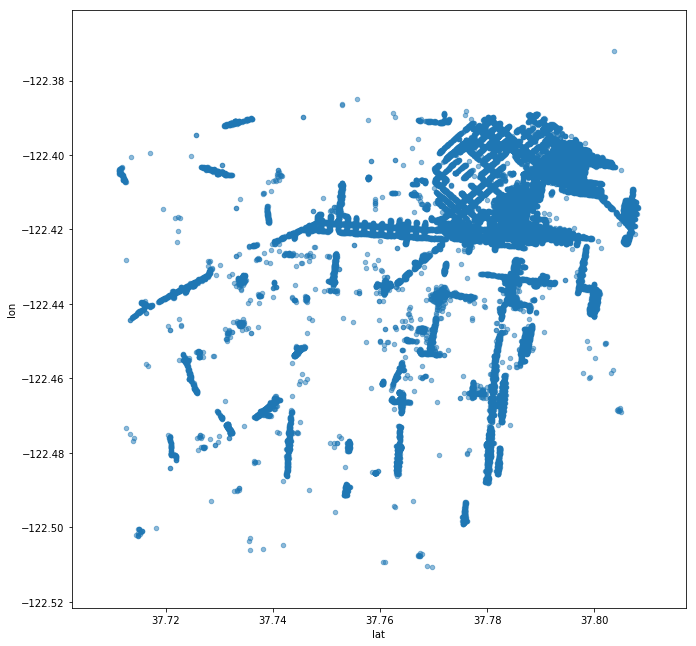

In [70]:
uni_loc.plot(x='lat',y='lon', kind='scatter', alpha=0.5, figsize=(11,11))

In [11]:
all_uniq = uni_loc[['lat','lon']].values



In [13]:
with open('all_lat_lon.csv', 'w') as f:
    for i in range(28159):
        f.write('%d,%f,%f\n' % (i, all_uniq[i,0], all_uniq[i,1]))

array([[  37.7113102 , -122.4041738 ],
       [  37.71131787, -122.40486554],
       [  37.71133635, -122.40498921],
       ..., 
       [  37.8080598 , -122.4140236 ],
       [  37.8080914 , -122.4141649 ],
       [  37.8081504 , -122.414177  ]])